# Webscrape and Data Cleaning/Manipulation of Pikes Peak Marathon Results

In [3]:
from urllib import urlopen
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
import numpy as np

### Data Scrape and manipulation
This code will scrape the Pikes Peak results data and parse it to separate csv files for each year 1976-2016.

In [8]:
error_years = []
for ii in range(1976,2017):
    page_addr = "http://www.pikespeakmarathon.org/results/"+str(ii)+"ppm_m.htm"
    file_path = "./PP_Data_Dump/"+str(ii)+".csv"
    if 1==1:
    #try:
        bsObj = bs(urlopen(page_addr).read(), "lxml")
        #the data table is in the "pre" field so grab it
        stuff = str(bsObj.pre)
        #process the file manually to get into appropriate csv format
        stuff = re.sub('<.*?>','', stuff)
        stuff = "POS "+stuff.split('POS ')[1] #Clear the header garbage    
        stuff = stuff.split("Note")[0] #Clear the foot garbage
        with open("./PP_Data_Dump/temp.csv","w") as f:
            f.write(stuff)
        #1987 line sample
        #  1    1/39  SHELDON A LARSON           27  25-29  BOULDER          CO  2:17:41  1:24:15  3:41:56
        #Sampel line
        # 16    4/20  VAL MURRAY                 17  COLORADO SPGS    CO  2:42:53  1:59:28  4:42:21
     
        first_line = True
        full_results = ""
        with open("./PP_Data_Dump/temp.csv", "r") as f:
            for line in f:
    
                line = list(line)
                if ii == 1987 and len(line) >= 89:
                    for jj in [3,12,38,43,50,67,71,80,89]:#,55,82,84,98]:#,104]:
                        line[jj] = ","
           
                    if line[0] == " ":
                        line.pop(0)
                    if line[0] == " ":
                        line.pop(0)
                    line = ''.join(line)
                    if first_line == True: #add a year column
                        line = "YEAR,"+line
                        first_line = False
                    else:
                        line = str(ii) + "," + line

                    for kk in range(0,25):
                        line = re.sub(", ", ",", line)
                        line = re.sub(" ,", ",", line)
                                          
                    full_results = full_results + line
                elif len(line) >= 82 and ii != 1987:
                    for jj in [3,12,38,43,60,64,73,82,91,100,109,118,127,
                               136,145,154,163,172,181,190,199,208,217,226]:
                        if jj < len(line)-1:
                            line[jj]=","
                    if line[0] == " ":
                        line.pop(0)
                    if line[0] == " ":
                        line.pop(0)
                    line = ''.join(line)
                    if first_line == True: #add a year column
                        line = "YEAR,"+line
                        first_line = False
                    else:
                        line = str(ii) + "," + line

                    for kk in range(0,25):
                        line = re.sub(", ", ",", line)
                        line = re.sub(" ,", ",", line)
                                          
                    full_results = full_results + line  
    
        with open(file_path, "w") as f:
            f.write(full_results)        
        


### To a single file:
The code below aggregates the data to a single csv file

In [379]:
all_years_df = pd.DataFrame(columns = ['YEAR', 'NAME','AGE','ASCENT','TOTAL'])
for year in range(1976, 2017):
    temp_df = pd.read_csv("./PP_Data_Dump/"+str(year)+".csv")
    temp_df = temp_df[['YEAR', 'NAME','AGE','ASCENT','TOTAL']]
    all_years_df = all_years_df.append(temp_df, ignore_index = True)
all_years_df.to_csv("./PP_Data_Dump/all_years.csv", index = False)    

In [3]:
all_years_df = pd.read_csv("./PP_Data_Dump/all_years.csv")
all_years_df.head()

,YEAR,NAME,AGE,ASCENT,TOTAL
0,1976,RICK TRUJILLO,28.0,2.165,3.571
1,1976,TED CASTANEDA,24.0,2.351,3.893
2,1976,ROBERT BUNNELL,25.0,2.438,3.917
3,1976,MACLEAN WILSON,18.0,2.388,3.968
4,1976,MIKE HARRIE,21.0,2.382,3.993


### Conversion of text string in Ascent and Total columns to decimal hours.

In [1]:
def convert_string_to_hours(text):
    if type(text) != str:
        return text
    else:
        if ';' in text:
            if len(re.split(';', text)) == 3:
                h = re.split(';', text)[0]
                m = re.split(';', text)[1]
                s = re.split(';', text)[2]
            else:
                a = re.split(';', text)[0]
                b = re.split(';', text)[1]

                if ':' in a:
                    h = re.split(':', a)[0]
                    m = re.split(':', a)[1]
                    s = b
                if ':' in b:
                    h = a
                    m = re.split(':', b)[0]
                    s = re.split(':', b)[1]
            return round((int(h) + int(m) / 60. + int(s) / 3600.), 3)
        else: 
            hms = text.split(":")
            if len(hms) != 3:
                #print("Error with {}".format(text))
                return float('nan')
            else:
                hours = int(hms[0]) + int(hms[1]) / 60. + int(hms[2]) / 3600.
                return round(hours, 3)



### Conversion of string to numeric data

In [382]:
def string_to_int(text):
    try:
        conv = int(text)
        return conv
    except:
        try:
            conv = int(float(text))
            return conv
        except:
            return float('nan')

    
#TESTING
A = [29.89, '29.89', 2989, 'po2989']
map(string_to_int, A)

[29, 29, 2989, nan]

In [383]:
all_years_df['ASCENT'] = map(convert_string_to_hours, all_years_df['ASCENT'])
all_years_df['TOTAL'] = map(convert_string_to_hours, all_years_df['TOTAL'])
print(all_years_df.head())

     YEAR            NAME   AGE  ASCENT  TOTAL
0  1976.0   RICK TRUJILLO  28.0   2.165  3.571
1  1976.0   TED CASTANEDA  24.0   2.351  3.893
2  1976.0  ROBERT BUNNELL  25.0   2.438  3.917
3  1976.0  MACLEAN WILSON  18.0   2.388  3.968
4  1976.0     MIKE HARRIE  21.0   2.382  3.993


In [384]:
all_years_df['AGE'] = map(string_to_int, all_years_df['AGE'])
all_years_df['YEAR'] = map(string_to_int, all_years_df['YEAR'])
all_years_df.head()

,YEAR,NAME,AGE,ASCENT,TOTAL
0,1976,RICK TRUJILLO,28.0,2.165,3.571
1,1976,TED CASTANEDA,24.0,2.351,3.893
2,1976,ROBERT BUNNELL,25.0,2.438,3.917
3,1976,MACLEAN WILSON,18.0,2.388,3.968
4,1976,MIKE HARRIE,21.0,2.382,3.993


In [385]:
all_years_df.head()
all_years_df['AGE'] = map(string_to_int, all_years_df['AGE'])

In [386]:
all_years_df.to_csv("./PP_Data_Dump/all_years.csv", index = False)

# All data cleaning / wrangling done, now to have a quick look inside :-)

In [4]:
all_years_df = pd.read_csv("./PP_Data_Dump/all_years.csv")

In [5]:
all_years_df.count()

YEAR      19159
NAME      19159
AGE       19095
ASCENT    18831
TOTAL     19158
dtype: int64

In [6]:
import matplotlib.pyplot as plt

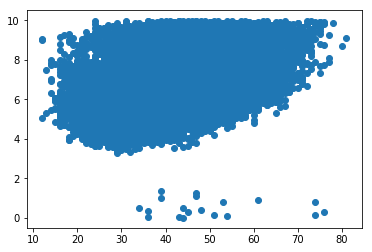

In [7]:
plt.scatter(all_years_df['AGE'], all_years_df['TOTAL'])
plt.show()

In [9]:
gb = all_years_df.groupby(by = ['AGE'])


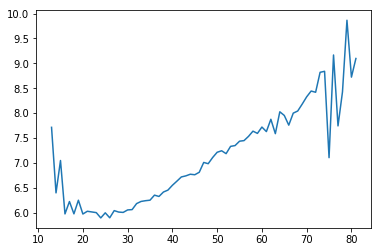

In [10]:
plt.plot(range(13,82), gb.mean()['TOTAL'])
plt.show()

In [15]:
gb2 = all_years_df.groupby(['YEAR','AGE']).aggregate(np.mean)

In [16]:
print(gb2)

             ASCENT     TOTAL
YEAR AGE                     
1976 15.0  3.363000  6.018000
     16.0  3.264750  5.154250
     17.0  3.102333  5.227333
     18.0  3.538000  5.854800
     19.0  3.437200  5.753200
     20.0  3.180333  5.722333
     21.0  3.278333  5.554167
     22.0  3.478333  5.398333
     23.0  3.412000  5.483750
     24.0  3.127250  5.204125
     25.0  2.924400  4.777400
     26.0  3.488400  5.788000
     27.0  3.538000  5.530125
     28.0  3.155857  5.162143
     29.0  3.676800  5.983700
     30.0  3.215833  5.215333
     31.0  3.245500  5.388500
     32.0  3.436571  5.515857
     33.0  3.548500  6.212000
     34.0  3.973400  6.662200
     35.0  3.933333  6.348000
     36.0  3.564750  5.670875
     37.0  3.874667  6.396667
     38.0  3.156000  4.768000
     39.0  3.580000  6.041800
     40.0  3.467400  5.801000
     41.0  3.328000  5.121000
     42.0  3.076000  5.184000
     43.0  3.210000  5.281000
     44.0  3.056000  4.784000
...             ...       ...
2016 43.0 